<a href="https://colab.research.google.com/github/AfsanehHabibi/reddit-conversation-quality/blob/main/Conversation_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
base_path = "/content/drive/MyDrive/University/RedditData/"

In [59]:
import pickle

with open(f"{base_path}conversations_remove_empty_with_topics_dataframe.pkl", 'rb') as file:
    df = pickle.load(file)

In [60]:
df = df.rename(columns={'politensess': 'politeness'})

In [61]:
import numpy as np

df['subreddit_subscribers'] = df['subreddit_subscribers'].replace(0, np.nan)

#Conversation-addation

In [62]:
df['conv-unweighted'] = df['norm_readability'] + df['norm_politeness'] + df['has_reasoning'] + df['evidence'] + df['relatedness']

In [63]:
df['conv-eq-maxim'] = 0.5*df['norm_readability'] + 0.5*df['norm_politeness'] + 0.5*df['has_reasoning'] + 0.5*df['evidence'] + df['relatedness']

#Column addition

In [64]:
df['reply_to'].nunique()

135487

In [65]:
def add_mean_for_reply(df, column):
  replies_df = df.loc[df['reply_to'].notnull()]
  mean_column = replies_df.groupby('reply_to')[column].mean()
  df = df.merge(mean_column.rename('mean_' + column + '_replies'), left_on='id', right_index=True, how='left')
  return df

In [66]:
df = add_mean_for_reply(df, 'norm_readability')
df = add_mean_for_reply(df, 'norm_politeness')
df = add_mean_for_reply(df, 'relatedness')
df = add_mean_for_reply(df, 'evidence')
df = add_mean_for_reply(df, 'has_reasoning')

In [67]:
maxims = ['norm_readability', 'norm_politeness', 'has_reasoning', 'evidence', 'relatedness']

In [68]:
maxim_mean_over_replies = ['mean_norm_readability_replies', 'mean_norm_politeness_replies', 'mean_has_reasoning_replies', 'mean_evidence_replies', 'mean_relatedness_replies']

In [69]:
def add_string_length(df, column):
    df['len_'+column] = df[column].apply(lambda x: len(x) if isinstance(x, str) else np.nan)
    return df

In [70]:
df = add_string_length(df, 'title')
df = add_string_length(df, 'text')

In [71]:
import numpy as np

def add_log(df, column):
  df['log_'+column] = np.log(df[column])
  return df

In [72]:
df = add_log(df, 'subreddit_subscribers')

In [73]:
# Function to calculate depth recursively
def calculate_depth(reply_dict, id, depth_cache):
    if id not in reply_dict or reply_dict[id] is None:
        return 0
    if id in depth_cache:
        return depth_cache[id]

    parent_id = reply_dict[id]
    depth = calculate_depth(reply_dict, parent_id, depth_cache) + 1
    depth_cache[id] = depth
    return depth

In [74]:
def add_depth(df):
  # Initialize the depth column with NaN
  df['depth'] = float('nan')

  # Create a dictionary to map id to reply_to
  reply_dict = dict(zip(df['id'], df['reply_to']))

  # Dictionary to cache depths to avoid recalculations
  depth_cache = {}

  # Calculate depth for each row
  df['depth'] = df['id'].apply(lambda x: calculate_depth(reply_dict, x, depth_cache))

In [75]:
add_depth(df)

In [76]:
df.head()

,id,conversation_id,reply_to,readability,evidence,has_reasoning,has_reasoning_one_shot,politeness,relatedness,subjectivity,...,conv-eq-maxim,mean_norm_readability_replies,mean_norm_politeness_replies,mean_relatedness_replies,mean_evidence_replies,mean_has_reasoning_replies,len_title,len_text,log_subreddit_subscribers,depth
0,xyt38s,xyt38s,None,-0.5,0.5,0,0.785905,0.095238,NaN,0.532381,...,NaN,0.65,0.058824,0.306438,0.333333,0.0,12.0,280,8.821732,0
1,iromk5a,xyt38s,xyt38s,-0.5,0.5,0,0.725411,0.095238,0.887727,0.532381,...,1.671550,NaN,NaN,NaN,NaN,NaN,NaN,276,8.821732,1
2,irpc624,xyt38s,xyt38s,-4.5,0.5,0,0.882337,0.000000,0.031587,0.000000,...,0.556587,NaN,NaN,NaN,NaN,NaN,NaN,60,8.821732,1
3,irp3pvs,xyt38s,xyt38s,-5.5,0.0,0,0.968893,0.047619,0.000000,0.400000,...,0.254412,NaN,NaN,NaN,NaN,NaN,NaN,19,8.821732,1
4,xyt38b,xyt38b,None,-2.5,0.5,1,0.390972,0.380952,NaN,0.415179,...,NaN,1.00,0.294118,0.262232,0.500000,1.0,66.0,694,14.904485,0


#Plots

##Scatter plot

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def scatter(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=column1, y=column2, data=df)
    plt.xlabel(f'{column1} of Original Row')
    plt.ylabel(f'{column2}')
    plt.title(f'Relationship between Original {column1} and {column2}')
    plt.show()


##Boxplot

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def boxplots_for_categorical_to_numerical(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column1, y=column2, data=df, fliersize=3)

    # Get the unique categories
    categories = df[column1].unique()

    # Set the x-axis tick labels
    plt.xticks(range(len(categories)), categories, rotation=90)

    plt.title(f'Boxplot for {column1} in respect to {column2}')
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.tight_layout()

    # the number of points in each boxplot
    #for i, box in enumerate(df.groupby(column1)[column2]):
    #   print(box[1].shape[0])

    plt.show()

##Density plot

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def density_for_numeric_to_numeric(df, column1, column2):
    plt.figure(figsize=(8, 6))
    sns.jointplot(x=column1, y=column2, data=df, kind='kde', cmap='viridis')
    plt.suptitle(f'Density between Original {column1} and {column2}')
    plt.tight_layout()
    plt.show()

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def density_for_numeric_to_numeric_simple(df, column1, column2):
    df['density'] = np.log1p(df.groupby([column1, column2])[column1].transform('count'))

    # Create a dummy scatter plot for colorbar mappable
    dummy = plt.scatter([], [], c=[], cmap='viridis', alpha=0.6, label='Density')

    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=column1, y=column2, hue='density', data=df, palette='viridis', alpha=0.6)
    plt.xlabel(f'{column1} of Original Row')
    plt.ylabel(f'{column2}')
    plt.title(f'Relationship between Original {column1} and {column2}')
    plt.colorbar(dummy)
    plt.legend()
    plt.show()

##Heatmap

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df, column1, column2):
  correlation = df[column1].corr(df[column2])

  plt.figure(figsize=(8, 6))
  sns.heatmap([[1, correlation], [correlation, 1]], annot=True, cmap='coolwarm', linewidths=.5, xticklabels=[column1, column2], yticklabels=[column1, column2])
  plt.title(f'Intensity Plot for Correlation between {column1} and {column2}')
  plt.show()

##Agreggation

In [26]:
#over correspond
def heatmap_and_density_for_correspond(column):
  density_for_numeric_to_numeric(df, column, 'norm_readability')
  heatmap_for_numeric_to_numeric(df, column, 'norm_readability')
  density_for_numeric_to_numeric(df, column, 'norm_politeness')
  heatmap_for_numeric_to_numeric(df, column, 'norm_politeness')
  density_for_numeric_to_numeric(df, column, 'has_reasoning')
  heatmap_for_numeric_to_numeric(df, column, 'has_reasoning')
  density_for_numeric_to_numeric(df, column, 'evidence')
  heatmap_for_numeric_to_numeric(df, column, 'evidence')
  density_for_numeric_to_numeric(df, column, 'relatedness')
  heatmap_for_numeric_to_numeric(df, column, 'relatedness')
  density_for_numeric_to_numeric(df, column, 'conv-unweighted')
  heatmap_for_numeric_to_numeric(df, column, 'conv-unweighted')
  density_for_numeric_to_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_numeric_to_numeric(df, column, 'conv-eq-maxim')

In [27]:
#over mean of reply
def heatmap_and_density_for_maxims(column):
  density_for_numeric_to_mean_numeric(df, column, 'norm_readability')
  heatmap_for_numeric_to_mean_numeric(df, column, 'norm_readability')
  density_for_numeric_to_mean_numeric(df, column, 'norm_politeness')
  heatmap_for_numeric_to_mean_numeric(df, column, 'norm_politeness')
  density_for_numeric_to_mean_numeric(df, column, 'has_reasoning')
  heatmap_for_numeric_to_mean_numeric(df, column, 'has_reasoning')
  density_for_numeric_to_mean_numeric(df, column, 'evidence')
  heatmap_for_numeric_to_mean_numeric(df, column, 'evidence')
  density_for_numeric_to_mean_numeric(df, column, 'relatedness')
  heatmap_for_numeric_to_mean_numeric(df, column, 'relatedness')
  density_for_numeric_to_mean_numeric(df, column, 'conv-unweighted')
  heatmap_for_numeric_to_mean_numeric(df, column, 'conv-unweighted')
  density_for_numeric_to_mean_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_numeric_to_mean_numeric(df, column, 'conv-eq-maxim')

In [28]:
def heatmap_and_density_for_strings_to_maxims(column):
  density_string_len_to_mean_numeric(df, column, 'norm_readability')
  heatmap_for_string_len_to_mean_numeric(df, column, 'norm_readability')
  density_string_len_to_mean_numeric(df, column, 'norm_politeness')
  heatmap_for_string_len_to_mean_numeric(df, column, 'norm_politeness')
  density_string_len_to_mean_numeric(df, column, 'has_reasoning')
  heatmap_for_string_len_to_mean_numeric(df, column, 'has_reasoning')
  density_string_len_to_mean_numeric(df, column, 'evidence')
  heatmap_for_string_len_to_mean_numeric(df, column, 'evidence')
  density_string_len_to_mean_numeric(df, column, 'relatedness')
  heatmap_for_string_len_to_mean_numeric(df, column, 'relatedness')
  density_string_len_to_mean_numeric(df, column, 'conv-unweighted')
  heatmap_for_string_len_to_mean_numeric(df, column, 'conv-unweighted')
  density_string_len_to_mean_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_string_len_to_mean_numeric(df, column, 'conv-eq-maxim')

In [29]:
def boxplot_to_mean_replies(column):
  for m in maxim_mean_over_replies:
    boxplots_for_categorical_to_numerical(df, column, m)

In [30]:
def boxplot_multiple(column, columns):
  for m in columns:
    boxplots_for_categorical_to_numerical(df, column, m)

#Statical test

##LM

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def lm(df, column1, column2):
    df = df.dropna(subset=[column1, column2])

    # Fit a linear regression model
    model = sm.OLS(df[column1], sm.add_constant(df[column2])).fit()

    # Get the fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Extract the test statistic and p-value
    bp_stat, bp_pvalue, f_pvalue, bp_fvalue = bp_test

    # Print the results
    print(f"Breusch-Pagan Test:")
    print(f"Test Statistic: {bp_stat:.4f}")
    print(f"P-value: {bp_pvalue:.4f}")

    # Check for autocorrelation using Durbin-Watson test
    dw_stat = durbin_watson(model.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

    if dw_stat < 1.5 or dw_stat > 2.5:
       print("Warning: Autocorrelation may be present in the model.")

    if bp_pvalue < 0.05:
        # Calculate weights based on the residuals
        weights = 1 / np.var(residuals)

        # Fit the WLS regression model
        wls_model = sm.WLS(df[column1], sm.add_constant(df[column2]), weights=weights).fit()

        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = wls_model.summary()

        if model.rsquared >= 0.025:
          print("relatively signicent!")
          density_for_numeric_to_numeric(df, column1, column2)
          heatmap(df, column1, column2)
        # Print the summary table
        print(summary_table)
    else:
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = model.summary()

        if model.rsquared >= 0.025:
          print("relatively signicent!")
          density_for_numeric_to_numeric(df, column1, column2)
          heatmap(df, column1, column2)
        # Print the summary table
        print(summary_table)

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def lm_multiple(df, dependent_var, independent_vars):
    df = df.dropna(subset=independent_vars)
    df = df.dropna(subset=[dependent_var])

    # Fit a multiple linear regression model
    model = ols(formula=f"{dependent_var} ~ {' + '.join([col for col in independent_vars])}", data=df).fit()

    # Get the fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Extract the test statistic and p-value
    bp_stat, bp_pvalue, f_pvalue, bp_fvalue = bp_test

    # Print the results
    print(f"Breusch-Pagan Test:")
    print(f"Test Statistic: {bp_stat:.4f}")
    print(f"P-value: {bp_pvalue:.4f}")

    # Check for autocorrelation using Durbin-Watson test
    dw_stat = durbin_watson(model.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

    if dw_stat < 1.5 or dw_stat > 2.5:
        print("Warning: Autocorrelation may be present in the model.")

    if bp_pvalue < 0.05:
        # Calculate weights based on the residuals
        weights = 1 / np.var(residuals)

        # Fit the WLS regression model
        wls_model = sm.WLS(df[dependent_var], sm.add_constant(df[[col for col in independent_vars]]), weights=weights).fit()

        if model.rsquared >= 0.1:
          print("relatively signicent!")
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = wls_model.summary()

        # Print the summary table
        print(summary_table)
    else:
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = model.summary()

        if model.rsquared >= 0.1:
          print("relatively signicent!")
        # Print the summary table
        print(summary_table)


###2-sample-ttest

In [33]:
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as stats

# Assuming df is your DataFrame
# and cat_column is the categorical variable
# and num_column is the numerical variable

def two_sample_ttest(df, cat_column, num_column, value1, value2):
  # Separate the data into two groups based on the category
  group1 = df[df[cat_column] == value1]
  group2 = df[df[cat_column] == value2]


  # Shapiro-Wilk test for normality
  _, pvalue1 = stats.shapiro(group1[num_column].dropna())
  _, pvalue2 = stats.shapiro(group2[num_column].dropna())

  print(f"Group 1 normality p-value: {pvalue1:.4f}")
  print(f"Group 2 normality p-value: {pvalue2:.4f}")

  # Calculate the means of the numerical variable for each group
  mean1 = group1[num_column].dropna().mean()
  mean2 = group2[num_column].dropna().mean()

  # Perform the 2-sample t-test
  t_stat, p_val = ttest_ind(group1[num_column].dropna(), group2[num_column].dropna())

  # Print the results
  print(f"Mean of category 1: {mean1}")
  print(f"Mean of category 2: {mean2}")
  print(f"t-statistic: {t_stat}")
  print(f"p-value: {p_val:.4f}")

  # Determine if the means are significantly different
  if p_val < 0.05:
    print("The means are significantly different.")
    boxplots_for_categorical_to_numerical(df, cat_column, num_column)
  else:
    print("The means are not significantly different.")

In [34]:
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu
import scipy.stats as stats

# Assuming df is your DataFrame
# and cat_column is the categorical variable
# and num_column is the numerical variable

def two_sample_wilcoxon(df, cat_column, num_column, value1, value2):
    # Separate the data into two groups based on the category
    group1 = df[df[cat_column] == value1][num_column].dropna()
    group2 = df[df[cat_column] == value2][num_column].dropna()

    # Perform the Wilcoxon rank-sum test
    if len(group1) == len(group2):
        stat, p_val = wilcoxon(group1, group2)
    else:
        stat, p_val = mannwhitneyu(group1, group2)

    # Print the results
    print(f"Wilcoxon rank-sum statistic: {stat}")
    print(f"p-value: {p_val:.4f}")

    # Determine if the groups have significantly different distributions
    if p_val < 0.05:
        print("The groups have significantly different distributions.")
    else:
        print("No significant difference between the groups.")
    # Ensure equal lengths
    min_length = min(len(group1), len(group2))
    group1 = np.random.choice(group1, min_length, replace=False)
    group2 = np.random.choice(group2, min_length, replace=False)
    print("Cohen's d:", cohens_d(group1, group2))
    print(f"Cliff's delta:{cliffs_delta(group1, group2):.4f}")
    print("Correlation coefficient:", correlation(group1, group2))

##Aggregation

In [35]:
def lm_to_mean_replies(column):
  for m in maxim_mean_over_replies:
    lm(df, column, m)

In [36]:
def two_sample_ttest_to_mean_replies(column, value1, value2):
  for m in maxim_mean_over_replies:
    two_sample_ttest(df, column, m, value1, value2)

In [37]:
def two_sample_wilcoxon_to_mean_replies(column, value1, value2):
  for m in maxim_mean_over_replies:
    two_sample_wilcoxon(df, column, m, value1, value2)

#Results

In [ ]:
lm_multiple(df, 'norm_politeness', ['norm_readability', 'norm_politeness', 'has_reasoning', 'evidence', 'relatedness', 'subjectivity', 'polarity'])

##Subjectivity to mean replies

In [38]:
lm_to_mean_replies('subjectivity')

Breusch-Pagan Test:
Test Statistic: 1930.0929
P-value: 0.0000
Durbin-Watson Statistic: 1.8766
                            WLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1773.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:18:03   Log-Likelihood:                -15544.
No. Observations:              130285   AIC:                         3.109e+04
Df Residuals:                  130283   BIC:                         3.111e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

##Polarity to mean replies

In [39]:
lm_to_mean_replies('polarity')

Breusch-Pagan Test:
Test Statistic: 138.7970
P-value: 0.0000
Durbin-Watson Statistic: 1.8837
                            WLS Regression Results                            
Dep. Variable:               polarity   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.837
Date:                Wed, 12 Jun 2024   Prob (F-statistic):             0.0279
Time:                        12:18:19   Log-Likelihood:                -1405.8
No. Observations:              130285   AIC:                             2816.
Df Residuals:                  130283   BIC:                             2835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------

##Politeness

Breusch-Pagan Test:
Test Statistic: 370.3111
P-value: 0.0000
Durbin-Watson Statistic: 1.6368
relatively signicent!


<Figure size 800x600 with 0 Axes>

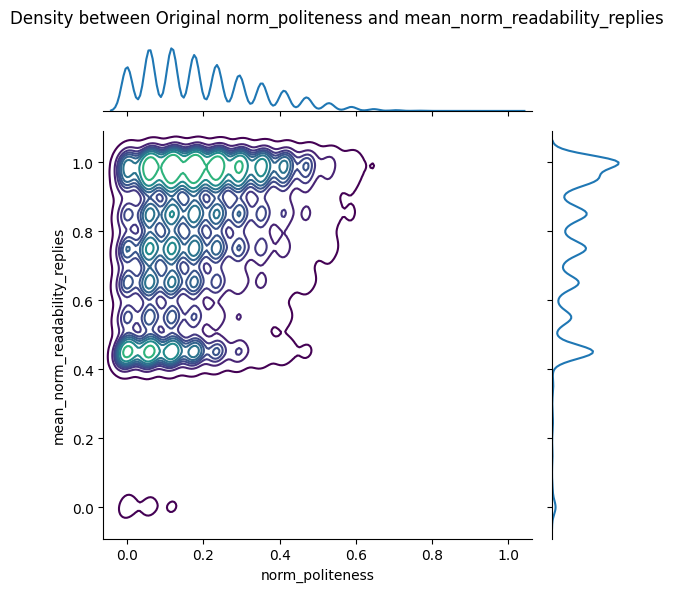

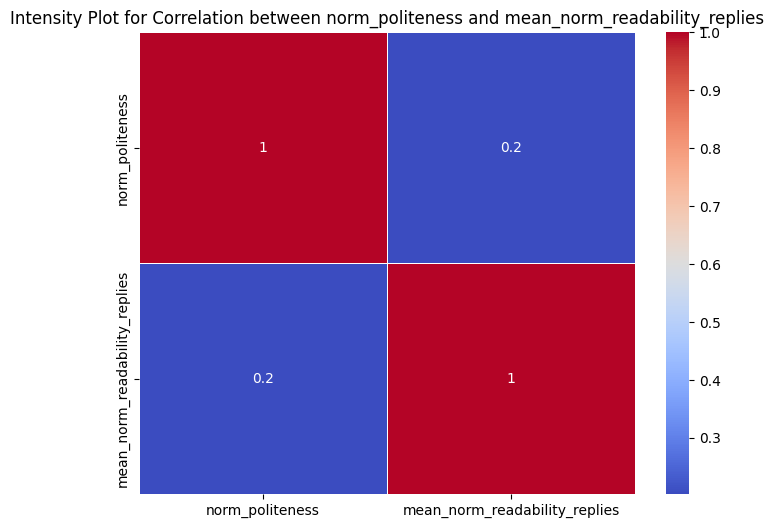

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.041
Model:                            WLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5826.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:40:41   Log-Likelihood:                 68595.
No. Observations:              135904   AIC:                        -1.372e+05
Df Residuals:                  135902   BIC:                        -1.372e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<Figure size 800x600 with 0 Axes>

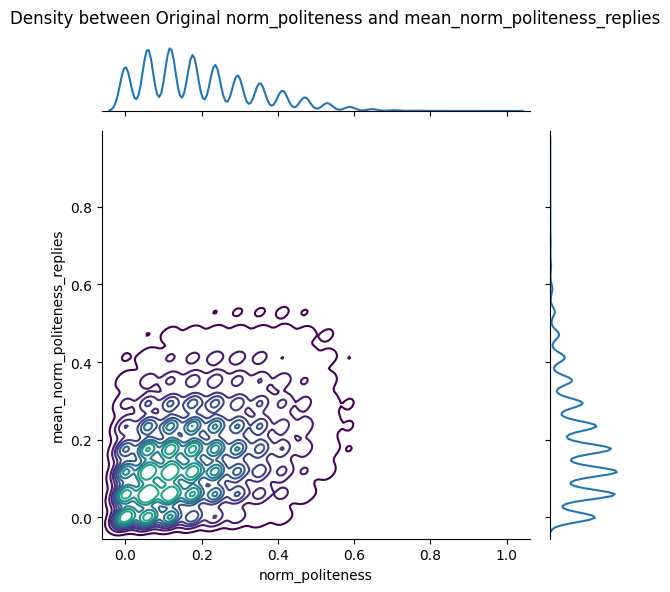

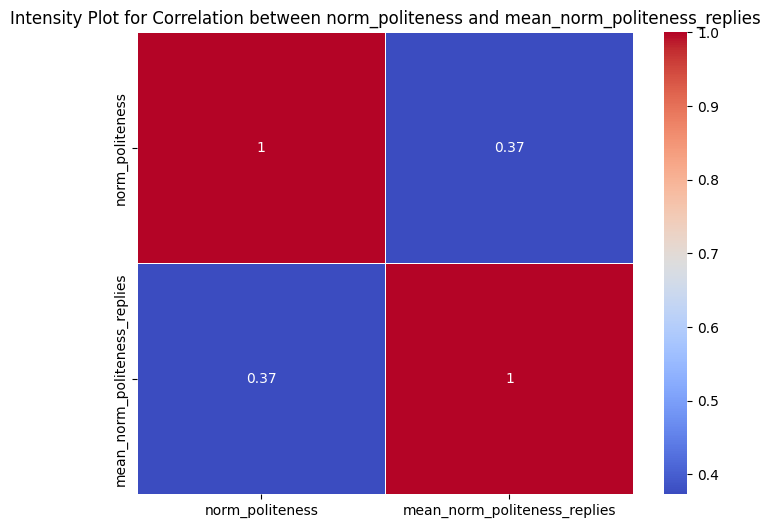

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.139
Model:                            WLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                 2.201e+04
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:42:48   Log-Likelihood:                 75943.
No. Observations:              135904   AIC:                        -1.519e+05
Df Residuals:                  135902   BIC:                        -1.519e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

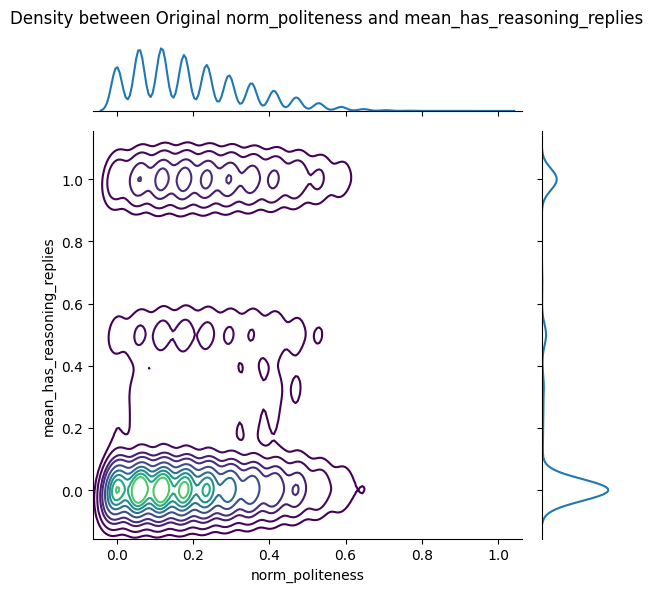

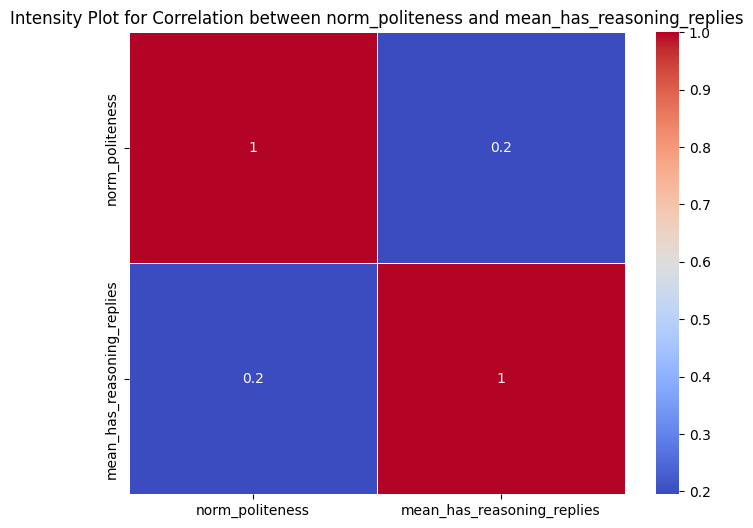

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5383.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:45:08   Log-Likelihood:                 68383.
No. Observations:              135904   AIC:                        -1.368e+05
Df Residuals:                  135902   BIC:                        -1.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Figure size 800x600 with 0 Axes>

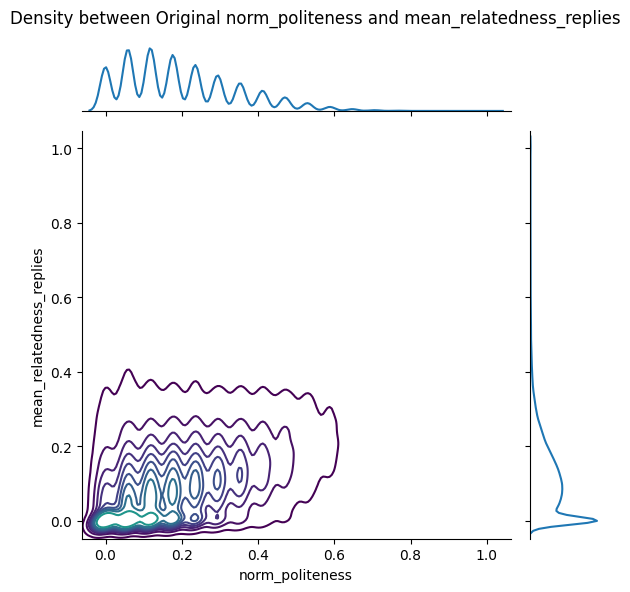

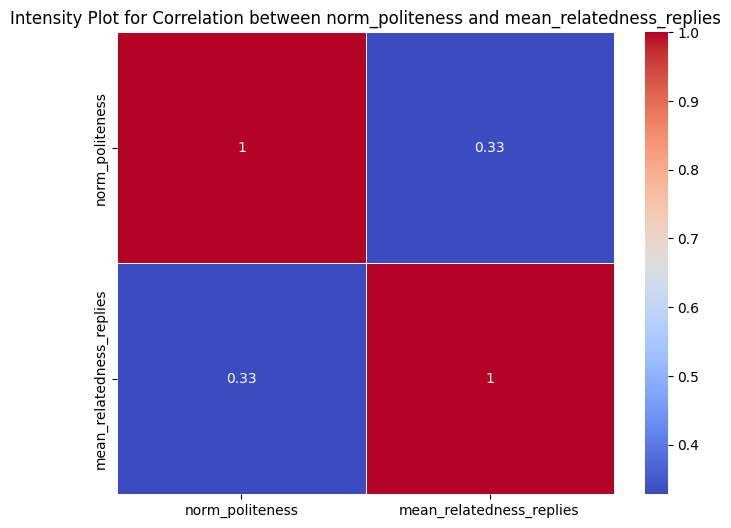

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.108
Model:                            WLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                 1.640e+04
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        14:47:07   Log-Likelihood:                 73485.
No. Observations:              135904   AIC:                        -1.470e+05
Df Residuals:                  135902   BIC:                        -1.469e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies('norm_politeness')

##Reasoning

In [ ]:
import scipy.stats as stats

# Shapiro-Wilk test for normality
_, pvalue1 = stats.shapiro(group1)
_, pvalue2 = stats.shapiro(group2)

print(f"Group 1 normality p-value: {pvalue1:.4f}")
print(f"Group 2 normality p-value: {pvalue2:.4f}")

In [ ]:
two_sample_wilcoxon()

In [ ]:
import numpy as np
from scipy.stats import rankdata, mannwhitneyu

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size."""
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((len(group1) - 1) * std1 ** 2 + (len(group2) - 1) * std2 ** 2) / (len(group1) + len(group2) - 2))
    d = (mean1 - mean2) / pooled_std
    return d

def cliffs_delta(group1, group2):
    """Calculate Cliff's delta effect size."""
    ranks1 = rankdata(group1)
    ranks2 = rankdata(group2)
    n1, n2 = len(group1), len(group2)
    delta = (sum(ranks1) - n1 * (n1 + 1) / 2 - sum(ranks2) + n2 * (n2 + 1) / 2) / (n1 * n2)
    return delta

def correlation(group1, group2):
    """Calculate correlation coefficient effect size."""
    return np.corrcoef(group1, group2)[0, 1]

# Example usage
group1 = np.array([5, 7, 9, 11, 13])
group2 = np.array([6, 8, 10, 12, 14])

print("Cohen's d:", cohens_d(group1, group2))
print("Cliff's delta:", cliffs_delta(group1, group2))
print("Correlation coefficient:", correlation(group1, group2))

Cohen's d: -0.31622776601683794
Cliff's delta: 0.0
Correlation coefficient: 0.9999999999999999


In [ ]:
two_sample_wilcoxon_to_mean_replies('has_reasoning', 0, 1)

Wilcoxon rank-sum statistic: 1433502483.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.27418932173765787
Cliff's delta:0.0000
Correlation coefficient: -0.003643737496808753
Wilcoxon rank-sum statistic: 1240127958.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.479916826414143
Cliff's delta:0.0000
Correlation coefficient: -0.0064314332393509924
Wilcoxon rank-sum statistic: 1420151983.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.3133023568570146
Cliff's delta:0.0000
Correlation coefficient: 0.0015027237548735832
Wilcoxon rank-sum statistic: 1572481098.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.11334086759607258
Cliff's delta:0.0000
Correlation coefficient: 0.0024527905415192078
Wilcoxon rank-sum statistic: 1135768395.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.4951166011909316
Cliff'

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Group 1 normality p-value: 0.0000
Group 2 normality p-value: 0.0000
Mean of category 1: 0.7518735344114883
Mean of category 2: 0.8092522937558522
t-statistic: -42.191075128473315
p-value: 0.0000
The means are significantly different.


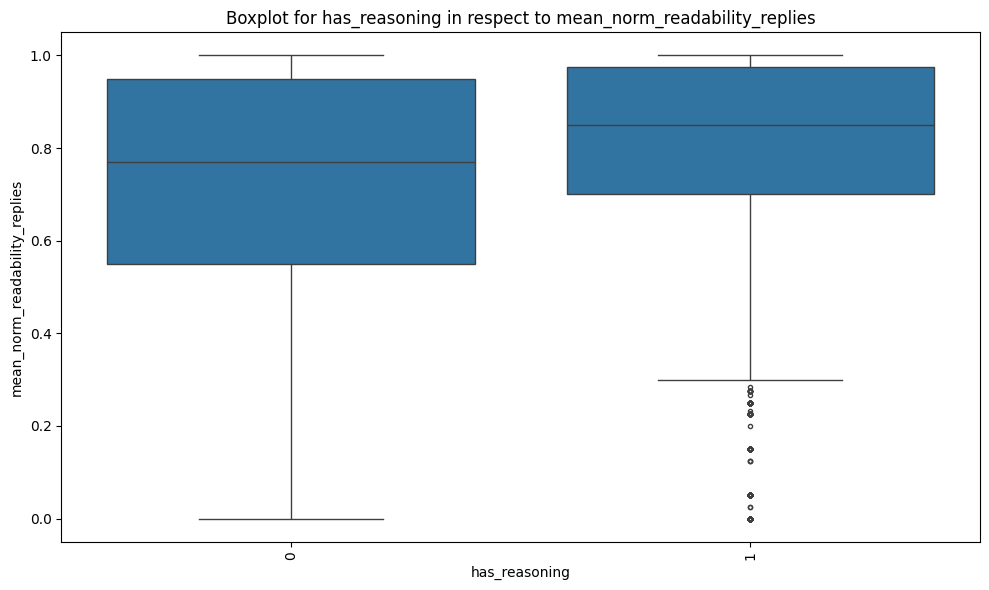

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Group 1 normality p-value: 0.0000
Group 2 normality p-value: 0.0000
Mean of category 1: 0.16120942157567006
Mean of category 2: 0.22430784673857554
t-statistic: -78.2214190529411
p-value: 0.0000
The means are significantly different.


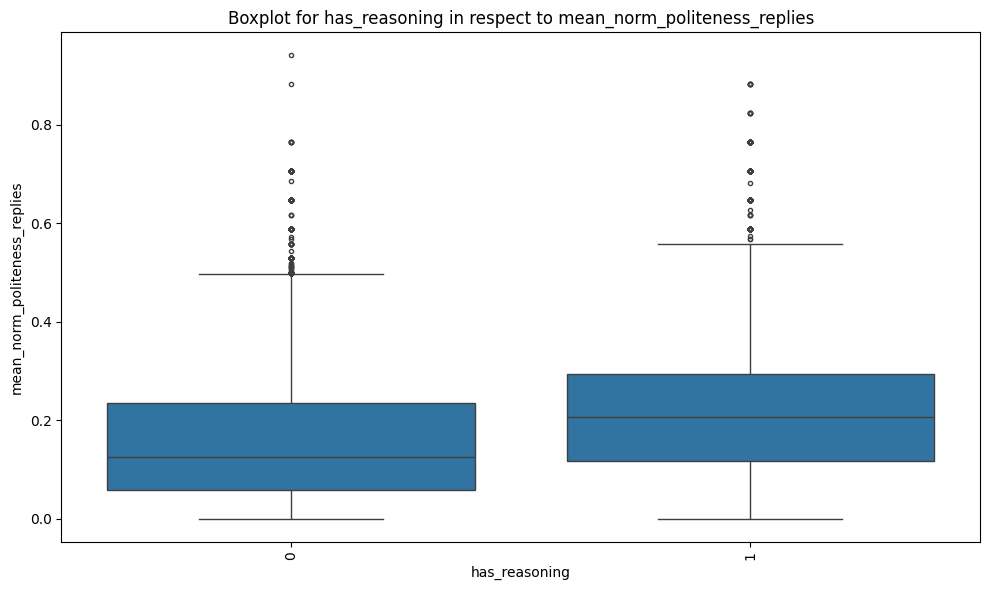

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Group 1 normality p-value: 0.0000
Group 2 normality p-value: 0.0000
Mean of category 1: 0.1786725397401204
Mean of category 2: 0.3005332401354187
t-statistic: -52.055357197979305
p-value: 0.0000
The means are significantly different.


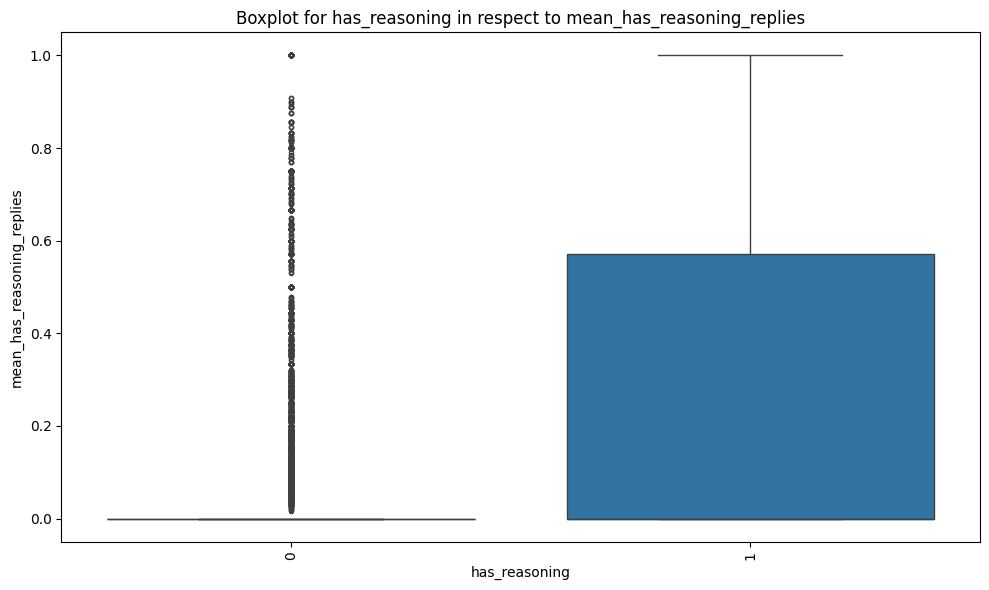

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Group 1 normality p-value: 0.0000
Group 2 normality p-value: 0.0000
Mean of category 1: 0.11431971280115145
Mean of category 2: 0.13921667278796937
t-statistic: -18.462479084894284
p-value: 0.0000
The means are significantly different.


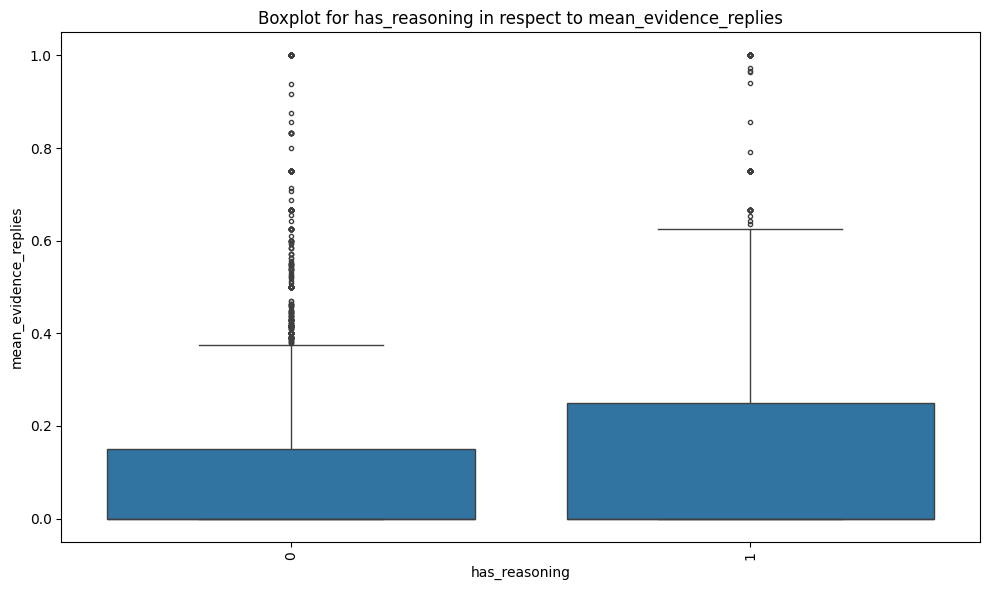

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Group 1 normality p-value: 0.0000
Group 2 normality p-value: 0.0000
Mean of category 1: 0.10388681814254729
Mean of category 2: 0.15985609532028439
t-statistic: -79.81343798289419
p-value: 0.0000
The means are significantly different.


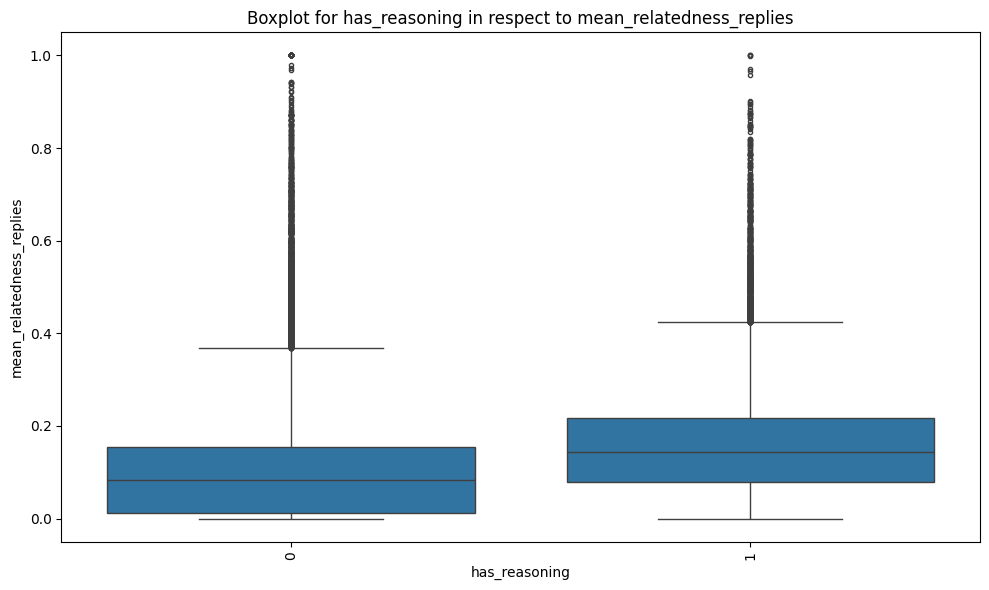

In [ ]:
two_sample_ttest_to_mean_replies('has_reasoning', 0, 1)

##Length title

In [40]:
lm_to_mean_replies('len_title')

Breusch-Pagan Test:
Test Statistic: 4.0520
P-value: 0.0441
Durbin-Watson Statistic: 2.0058
                            WLS Regression Results                            
Dep. Variable:              len_title   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.006955
Date:                Wed, 12 Jun 2024   Prob (F-statistic):              0.934
Time:                        12:19:05   Log-Likelihood:                -63280.
No. Observations:               13025   AIC:                         1.266e+05
Df Residuals:                   13023   BIC:                         1.266e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------

##Text length

Breusch-Pagan Test:
Test Statistic: 1.6941
P-value: 0.1931
Durbin-Watson Statistic: 1.7778
                            OLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1227.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          1.19e-267
Time:                        12:19:16   Log-Likelihood:            -1.0110e+06
No. Observations:              130285   AIC:                         2.022e+06
Df Residuals:                  130283   BIC:                         2.022e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------

<Figure size 800x600 with 0 Axes>

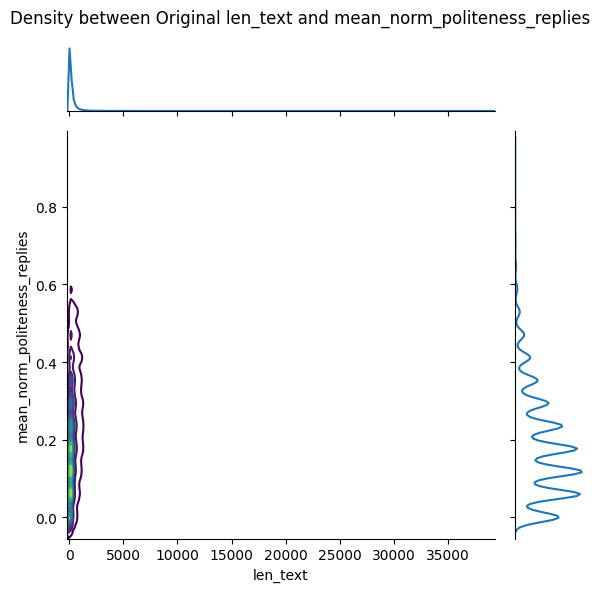

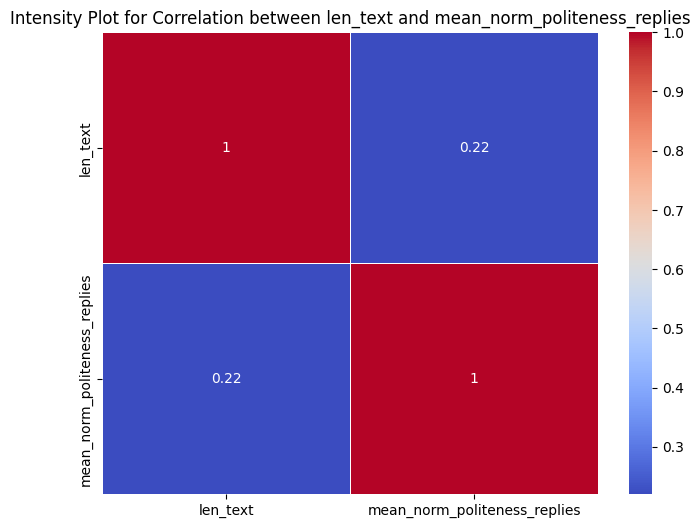

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.048
Model:                            WLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     6625.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:19:16   Log-Likelihood:            -1.0084e+06
No. Observations:              130285   AIC:                         2.017e+06
Df Residuals:                  130283   BIC:                         2.017e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

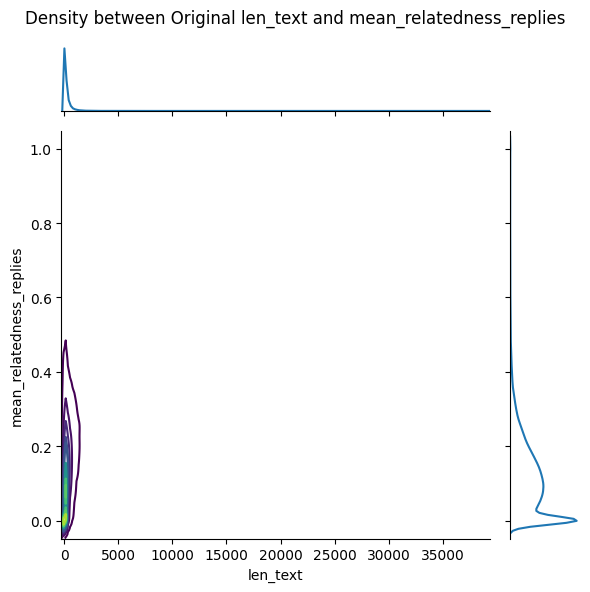

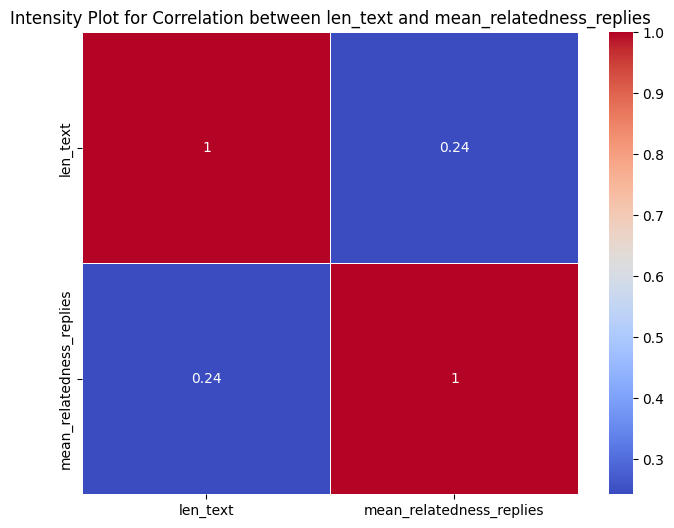

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.059
Model:                            WLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8180.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:21:22   Log-Likelihood:            -1.0076e+06
No. Observations:              130285   AIC:                         2.015e+06
Df Residuals:                  130283   BIC:                         2.015e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [41]:
lm_to_mean_replies('len_text')

##Readability

Breusch-Pagan Test:
Test Statistic: 535.1042
P-value: 0.0000
Durbin-Watson Statistic: 1.9017
relatively signicent!


<Figure size 800x600 with 0 Axes>

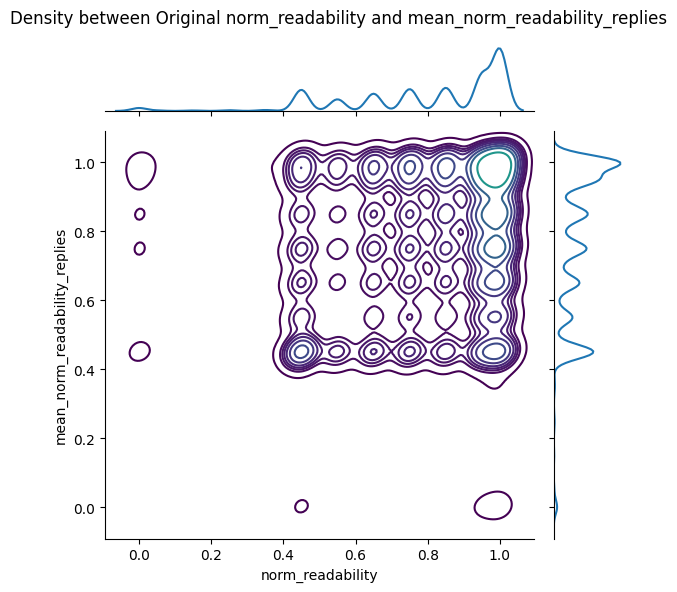

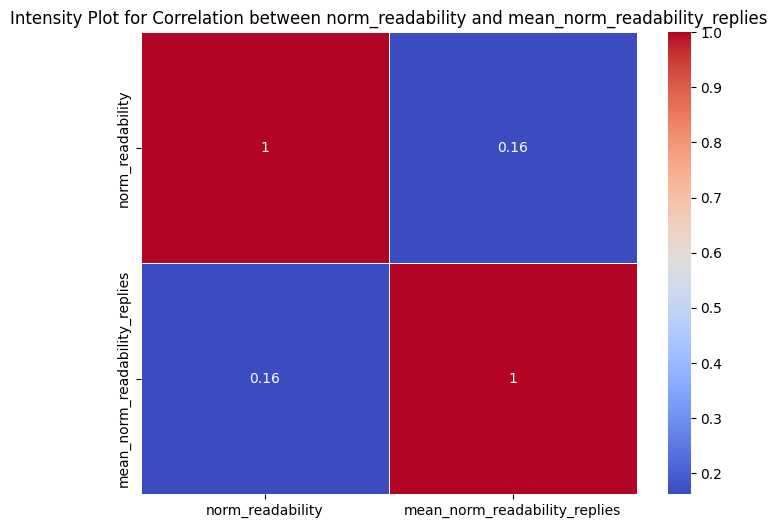

                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.026
Model:                            WLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3506.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:24:10   Log-Likelihood:                 12415.
No. Observations:              130285   AIC:                        -2.483e+04
Df Residuals:                  130283   BIC:                        -2.481e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<Figure size 800x600 with 0 Axes>

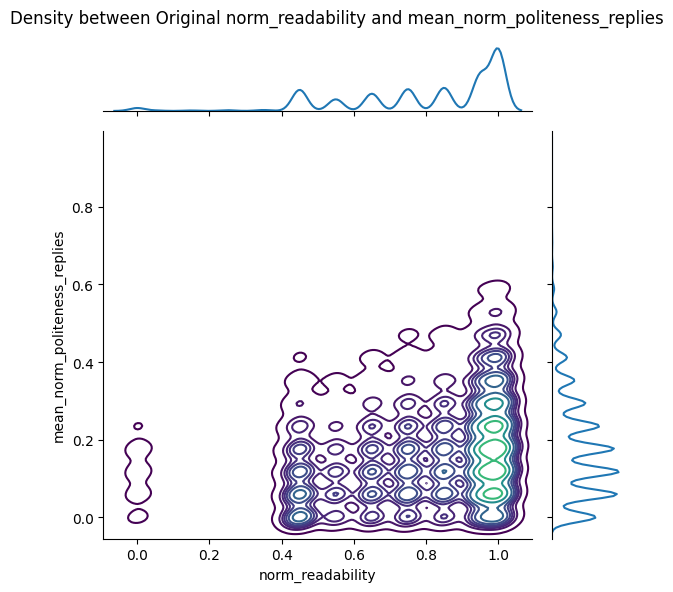

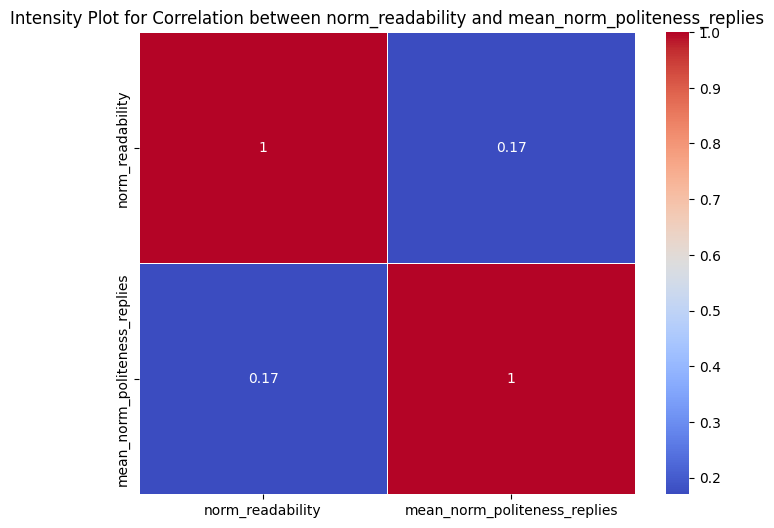

                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3887.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:25:52   Log-Likelihood:                 12601.
No. Observations:              130285   AIC:                        -2.520e+04
Df Residuals:                  130283   BIC:                        -2.518e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [42]:
lm_to_mean_replies('norm_readability')

##Subreddit

In [ ]:
lm_to_mean_replies('log_subreddit_subscribers')

Breusch-Pagan Test:
Test Statistic: 30.3672
P-value: 0.0000
Durbin-Watson Statistic: 0.3009
                                WLS Regression Results                               
Dep. Variable:     log_subreddit_subscribers   R-squared:                       0.000
Model:                                   WLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     3.792
Date:                       Tue, 28 May 2024   Prob (F-statistic):             0.0515
Time:                               14:31:34   Log-Likelihood:            -3.1153e+05
No. Observations:                     135808   AIC:                         6.231e+05
Df Residuals:                         135806   BIC:                         6.231e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                    coef    std 

In [ ]:
lm_to_mean_replies('subreddit_subscribers')

Breusch-Pagan Test:
Test Statistic: 73.2032
P-value: 0.0000
Durbin-Watson Statistic: 0.2742
                              WLS Regression Results                             
Dep. Variable:     subreddit_subscribers   R-squared:                       0.000
Model:                               WLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     37.73
Date:                   Tue, 28 May 2024   Prob (F-statistic):           8.15e-10
Time:                           14:31:27   Log-Likelihood:            -2.3244e+06
No. Observations:                 135808   AIC:                         4.649e+06
Df Residuals:                     135806   BIC:                         4.649e+06
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025   

##Subreddit topic

In [ ]:
df['topic'].value_counts()

topic
unknown          170737
media             42584
sport             22037
personal          18061
entertainment     16639
demographic       12484
health             7436
hobby              4569
finance            4321
politic            3690
news               2435
religion           1723
sharing            1272
tech                758
food                715
gaming              678
society             615
education           561
psychology          550
music               475
career              405
community           402
travel              259
Name: count, dtype: int64

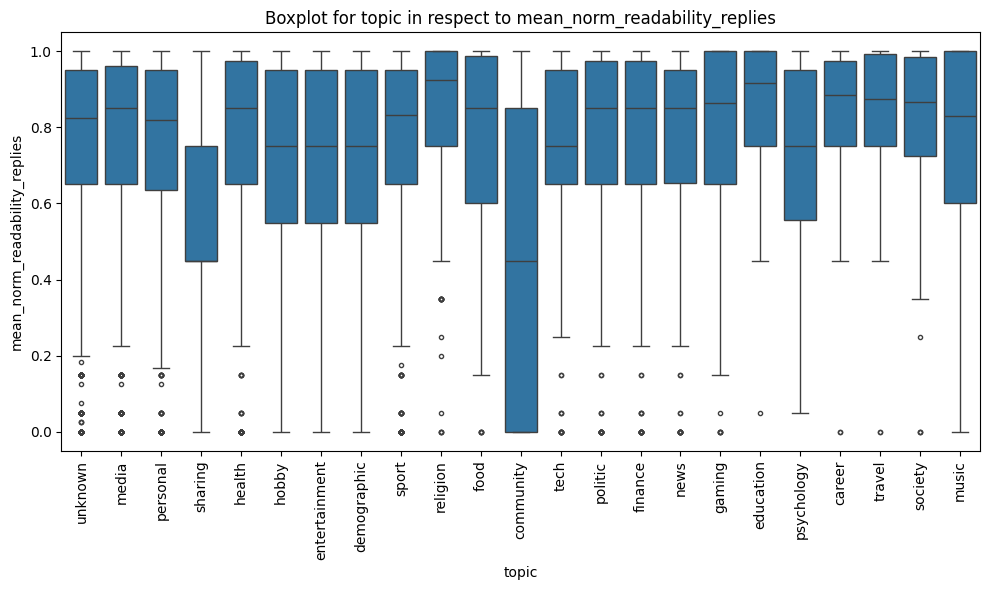

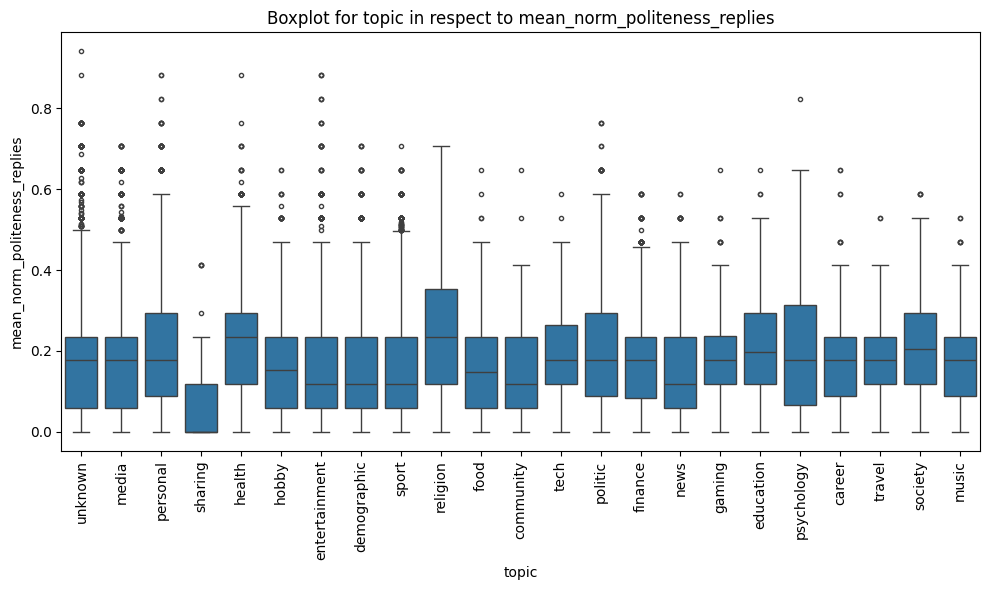

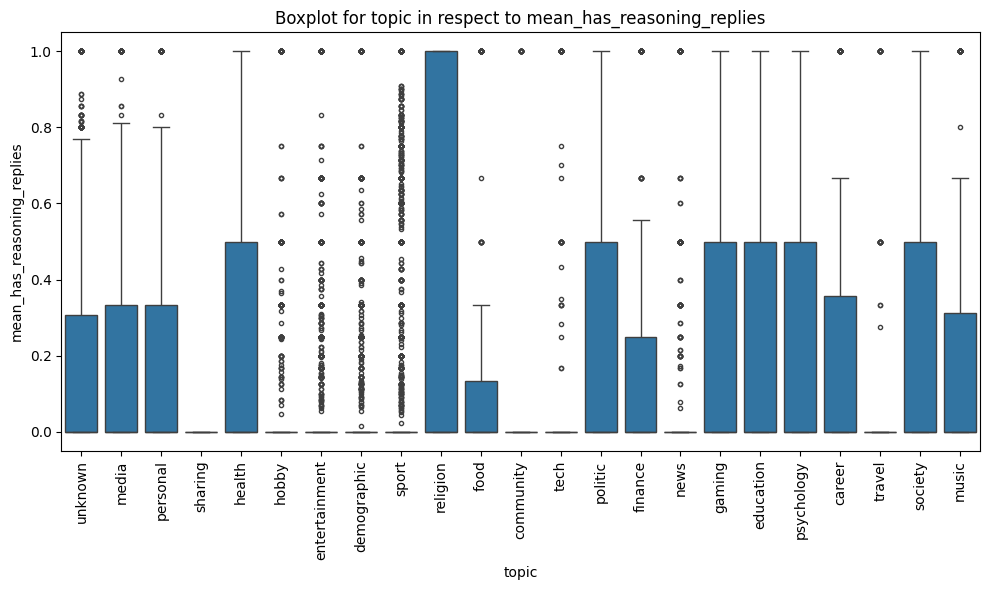

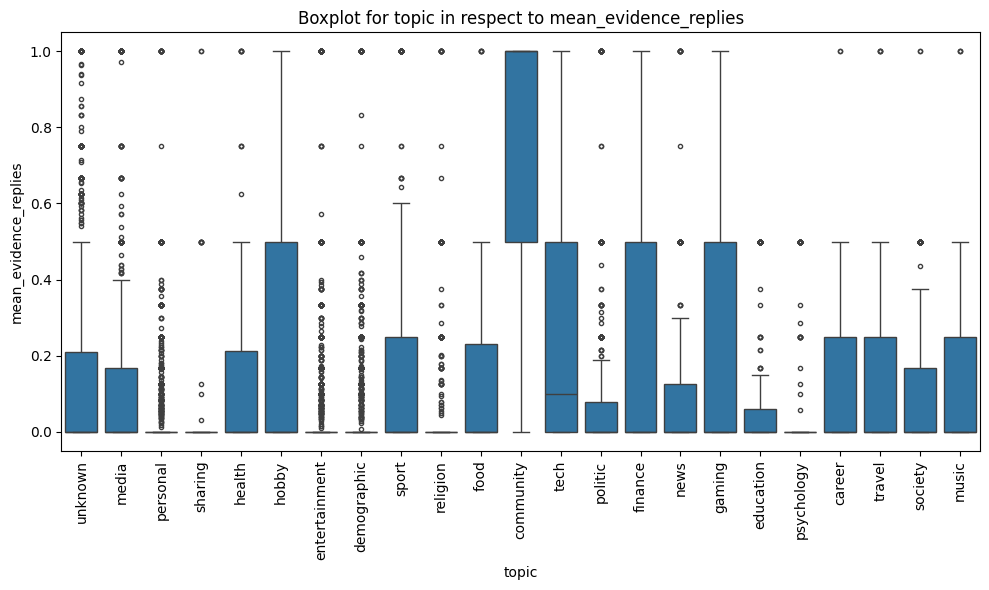

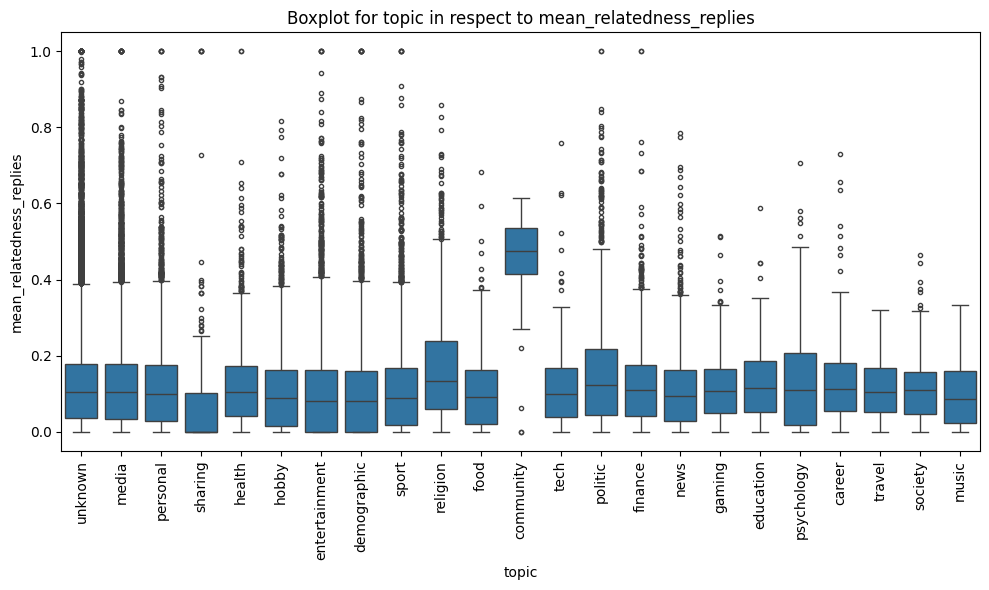

In [43]:
boxplot_to_mean_replies('topic')

In [ ]:
# Perform the ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import numpy as np

def anova(df, cat_column, num_column):
    # Convert the categorical variable to a categorical type
    df[cat_column] = df[cat_column].astype('category')

    # Drop rows with NaN values
    df[cat_column] = df[cat_column].replace('unknown', np.nan)
    df = df.dropna(subset=[cat_column, num_column])

    model = ols(f'{num_column} ~ C({cat_column})', data=df).fit()
    anova_result = anova_lm(model, typ=2)

    # Print the ANOVA table
    print(anova_result)

# Call the function
anova(df, 'topic', 'mean_norm_politeness_replies')

              sum_sq       df          F  PR(>F)
C(topic)   33.225160     21.0  94.190628     0.0
Residual  966.383631  57532.0        NaN     NaN


In [ ]:
anova(df, 'topic', 'mean_norm_politeness_replies')

TypeError: data type 'topic' not understood

##Depth

In [150]:
# Count the frequency of each subreddit
depth_counts = df['depth'].value_counts()

# Print the subreddits with the highest frequency
depth_counts[30:]
depth_counts[0]

19951

In [143]:
depth_counts = depth_counts.sort_values(ascending=True)

In [144]:
depth_counts

depth
70         1
49         1
50         1
51         1
59         1
       ...  
0      19951
4      20275
3      36199
2      68114
1     129840
Name: count, Length: 71, dtype: int64

In [145]:
depth_sum = depth_counts.cumsum()

depth
70         1
49         2
50         3
51         4
59         5
       ...  
0      53015
4      73290
3     109489
2     177603
1     307443
Name: count, Length: 71, dtype: int64

In [151]:
new_depth = {}
last = len(depth_sum) - 1
sum = 0
for i in range(len(depth_sum)):
  j = len(depth_sum) - i - 1
  if depth_counts[j] >= 30:
    new_depth[j] = j
  else:
    if sum + depth_counts[j] >= 30:
      new_depth[j] = last
      sum = 0
      last = j
    else:
      sum += depth_counts[j]
      new_depth[j] = last


In [154]:
df['merged_depth'] = [new_depth.get(x) for x in df['depth']]

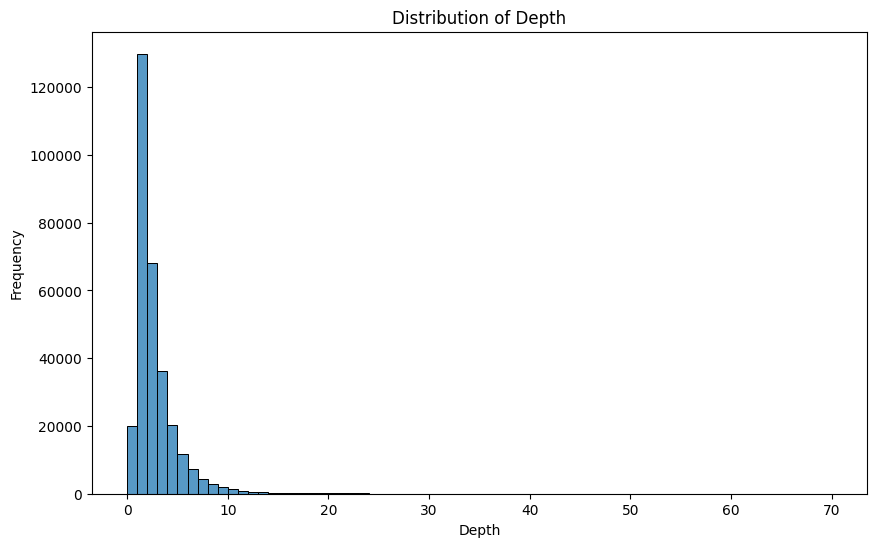

In [88]:
# Histogram plot for depth distribution
def plot_depth_histogram(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['depth'], bins=range(df['depth'].min(), df['depth'].max() + 1), kde=False)
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    plt.title('Distribution of Depth')
    plt.show()

# Call the function to plot the histogram
plot_depth_histogram(df)


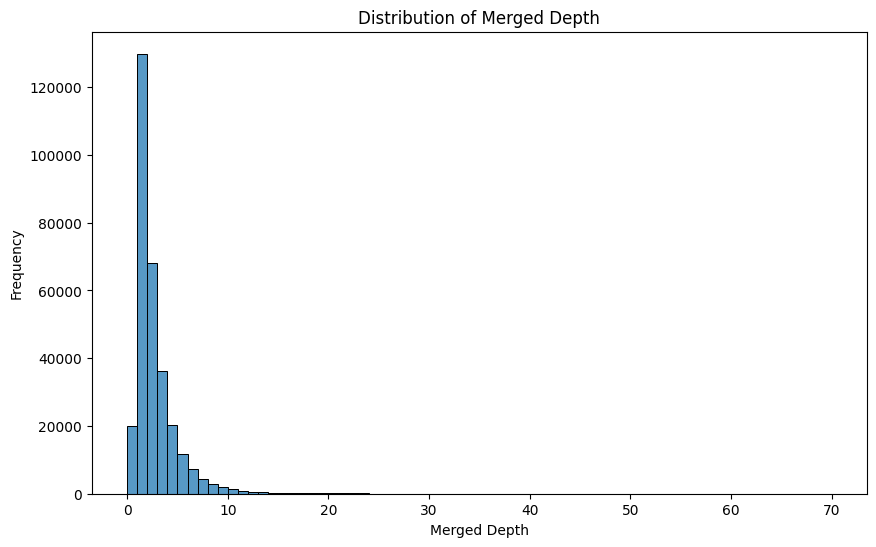

In [160]:
def plot_merged_depth_histogram(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['merged_depth'], bins=range(df['merged_depth'].min(), df['merged_depth'].max() + 1), kde=False)
    plt.xlabel('Merged Depth')
    plt.ylabel('Frequency')
    plt.title('Distribution of Merged Depth')
    plt.show()

# Call the function to plot the histogram
plot_merged_depth_histogram(df)

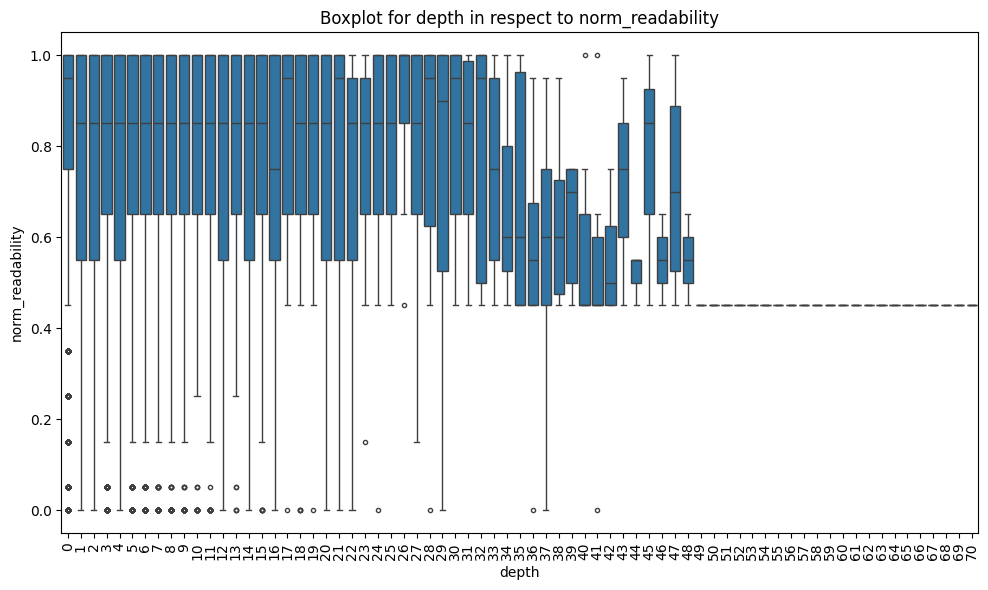

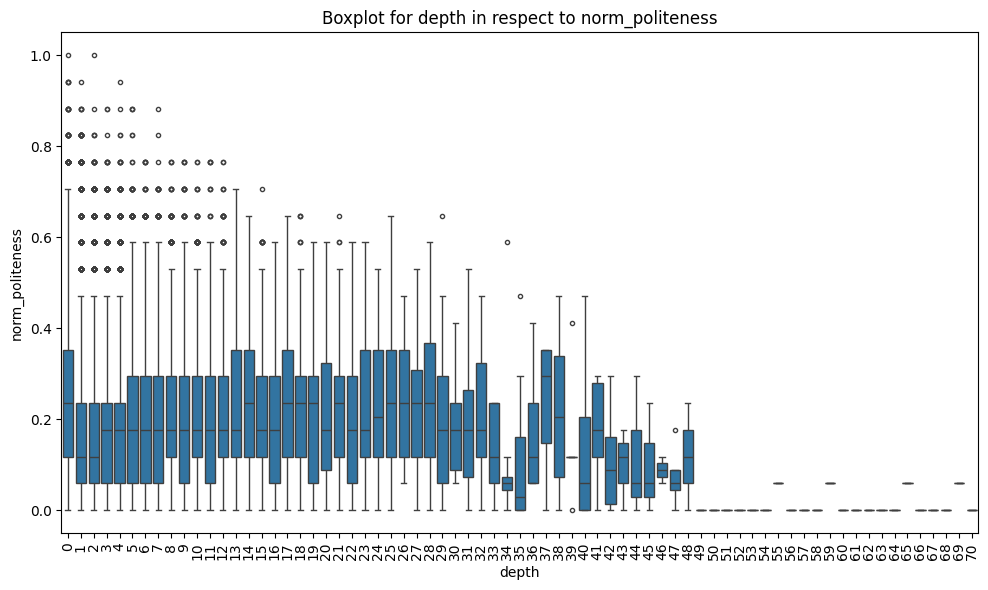

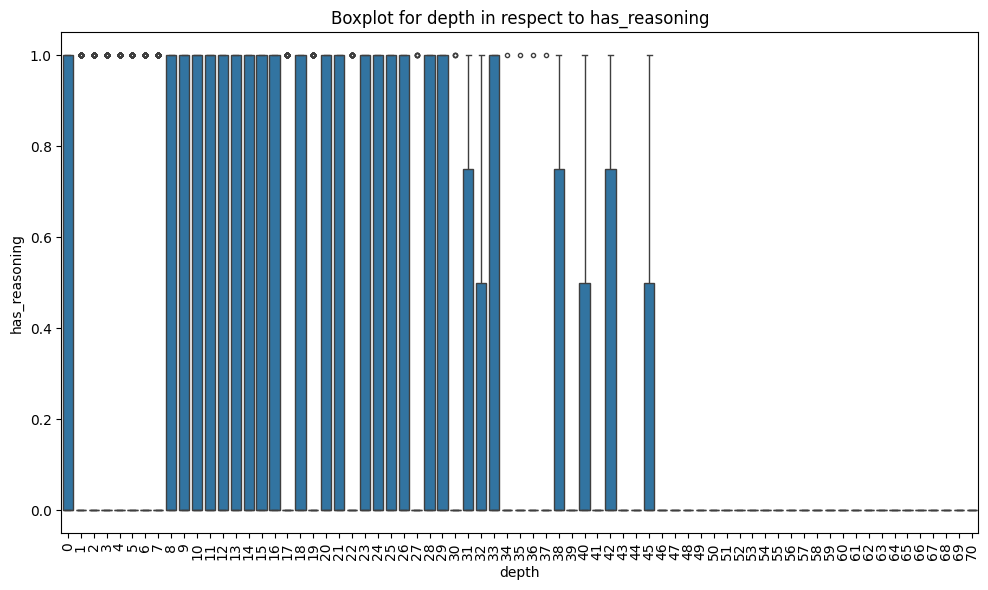

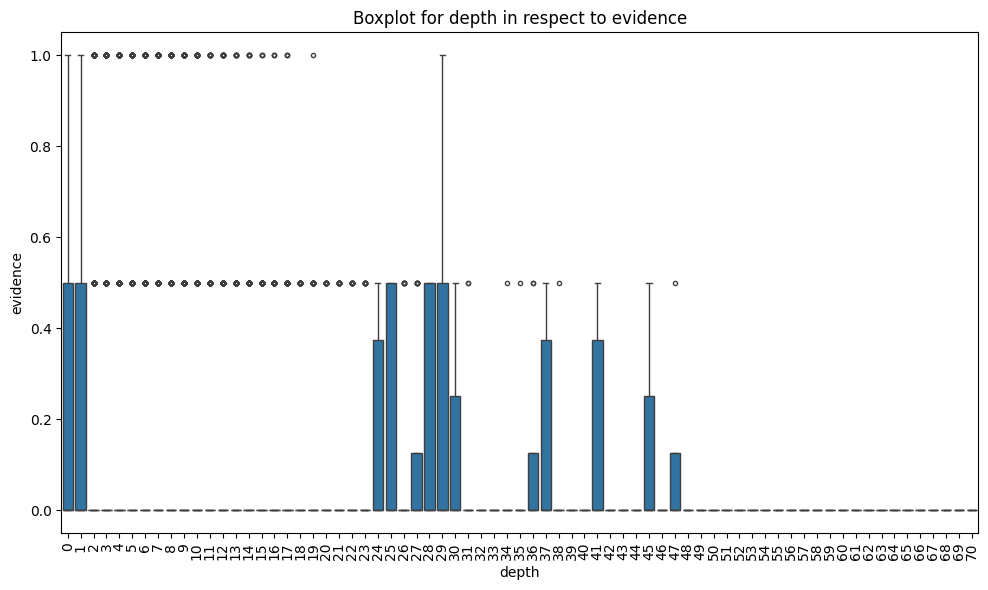

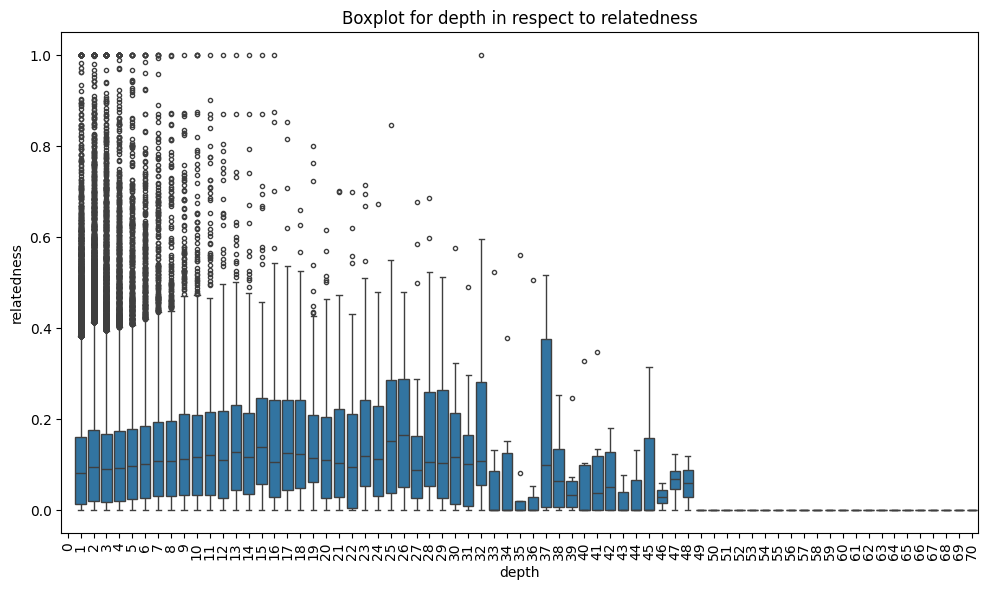

In [89]:
boxplot_multiple('depth', maxims)

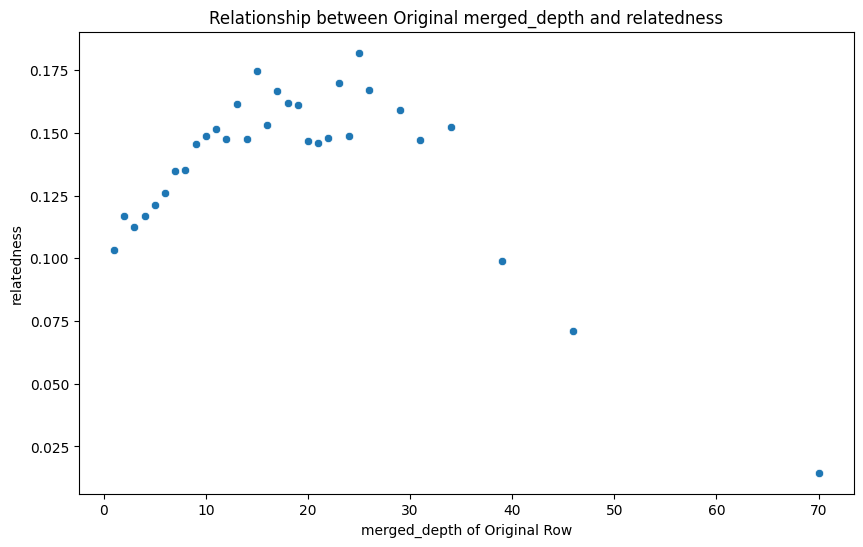

In [155]:
# Group by depth and calculate mean score
mean_scores = df.groupby('merged_depth')['relatedness'].mean().reset_index()

# Call the scatter function
scatter(mean_scores, 'merged_depth', 'relatedness')

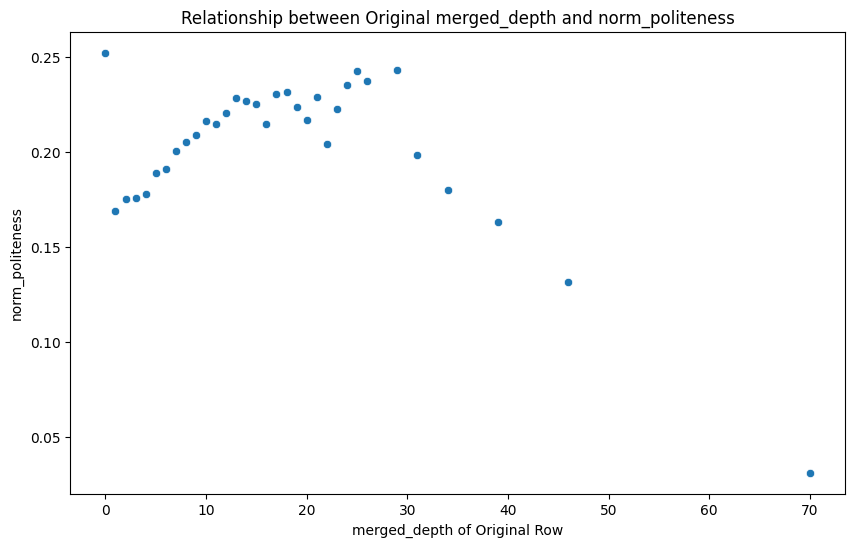

In [156]:
# Group by depth and calculate mean score
mean_scores = df.groupby('merged_depth')['norm_politeness'].mean().reset_index()

# Call the scatter function
scatter(mean_scores, 'merged_depth', 'norm_politeness')

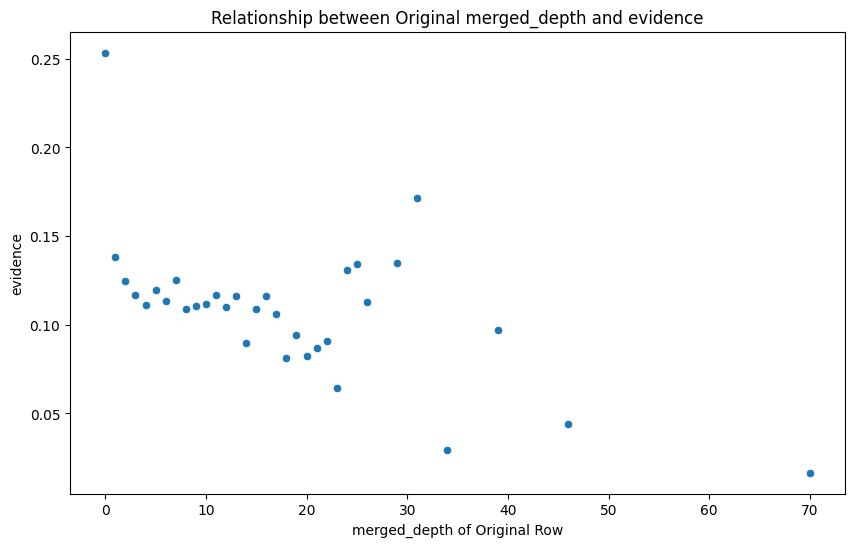

In [157]:
# Group by depth and calculate mean score
mean_scores = df.groupby('merged_depth')['evidence'].mean().reset_index()

# Call the scatter function
scatter(mean_scores, 'merged_depth', 'evidence')

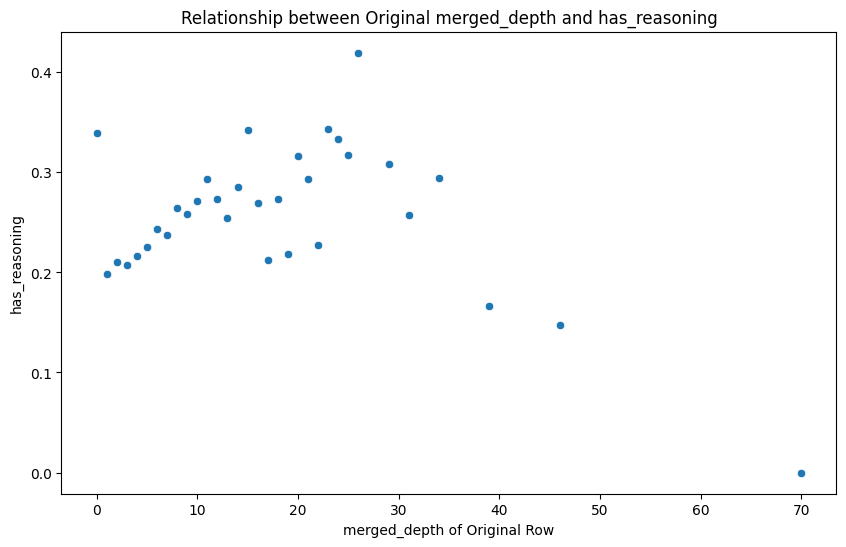

In [158]:
# Group by depth and calculate mean score
mean_scores = df.groupby('merged_depth')['has_reasoning'].mean().reset_index()

# Call the scatter function
scatter(mean_scores, 'merged_depth', 'has_reasoning')

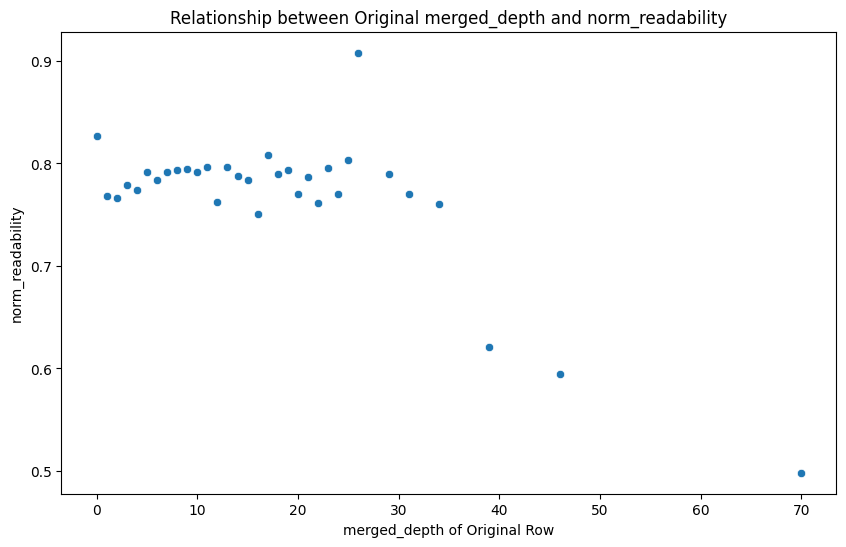

In [159]:
# Group by depth and calculate mean score
mean_scores = df.groupby('merged_depth')['norm_readability'].mean().reset_index()

# Call the scatter function
scatter(mean_scores, 'merged_depth', 'norm_readability')